In [1]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.7/776.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install custatevec-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 32.7 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn matplotlib

Running Hybrid Quantum K-Means...
Running Classical K-Means...


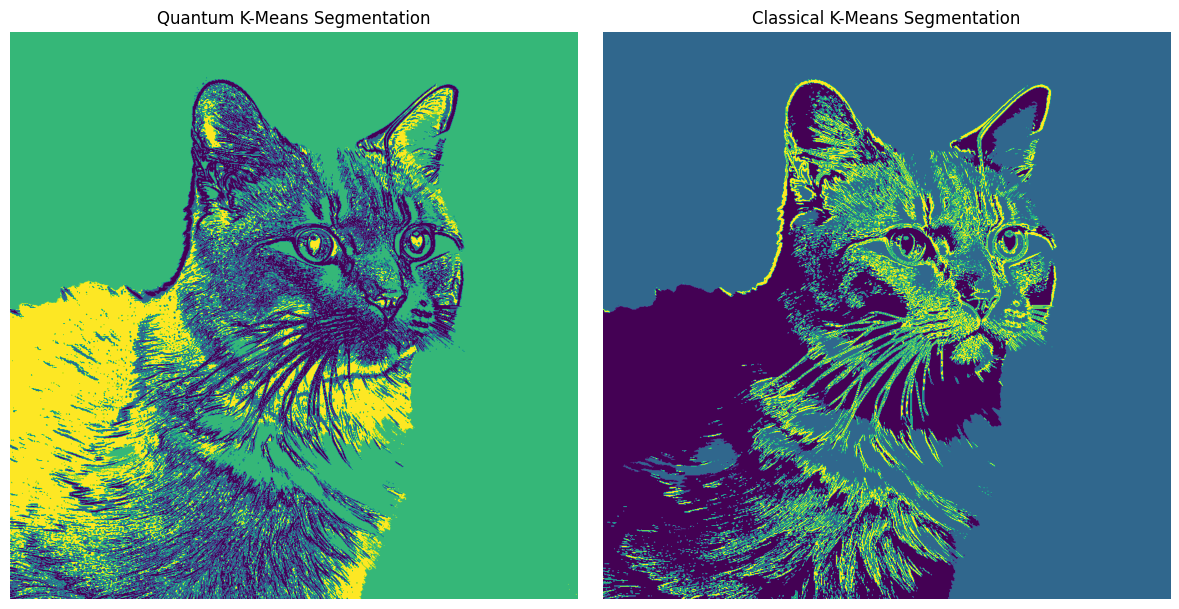

Segmentation comparison saved to improved_segmentation_comparison.png.
Average IoU Score between Quantum and Classical segmentations: 0.0280


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.filters import sobel
from PIL import Image

# Quantum device setup
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

def initialize_qubits(data):
    """Quantum oracle initialization of data centroids."""
    @qml.qnode(dev)
    def encode(state):
        for i, val in enumerate(state):
            qml.RY(val * np.pi, wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(len(state))]

    encoded_states = []
    for point in data:
        normalized = point / np.linalg.norm(point)  # Normalize for quantum gates
        encoded_states.append(encode(normalized))
    return np.array(encoded_states)

def hybrid_kmeans(data, k, max_iters=10):
    """Hybrid Quantum-Classical K-Means clustering."""
    classical_kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(data)
    centroids = classical_kmeans.cluster_centers_
    quantum_centroids = initialize_qubits(centroids)

    for iteration in range(max_iters):
        labels = []
        for point in data:
            distances = [np.linalg.norm(point - c) for c in quantum_centroids]
            labels.append(np.argmin(distances))

        labels = np.array(labels)
        unique_labels = len(set(labels))
        if unique_labels <= 1:
            centroids = classical_kmeans.cluster_centers_  # Fallback to classical centroids
            quantum_centroids = initialize_qubits(centroids)
            continue

        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(axis=0)

        quantum_centroids = initialize_qubits(centroids)

    return centroids, labels

def preprocess_image(image_path):
    """Preprocess image with additional features."""
    image = Image.open(image_path).convert("L")
    image_data = np.array(image) / 255.0  # Normalize to [0, 1]

    # Extract additional features (e.g., edges)
    edges = sobel(image_data)
    flat_data = np.stack((image_data.flatten(), edges.flatten()), axis=1)

    # Standardize features for better clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(flat_data)
    return image_data, scaled_data

def visualize_results(image_data, labels_quantum, labels_classical, save_path):
    """Visualize Quantum vs Classical K-Means results."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(labels_quantum.reshape(image_data.shape[:2]), cmap='viridis')
    axes[0].set_title("Quantum K-Means Segmentation")
    axes[0].axis('off')

    axes[1].imshow(labels_classical.reshape(image_data.shape[:2]), cmap='viridis')
    axes[1].set_title("Classical K-Means Segmentation")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Input: Path to custom image
    custom_img_path = "/content/out-0-1.png"

    # Preprocess the image
    image_data, processed_data = preprocess_image(custom_img_path)

    # Parameters
    k = 4
    max_iters = 10

    # Apply Hybrid Quantum K-Means
    print("Running Hybrid Quantum K-Means...")
    quantum_centroids, quantum_labels = hybrid_kmeans(processed_data, k, max_iters)

    # Apply Classical K-Means
    print("Running Classical K-Means...")
    classical_kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(processed_data)
    classical_labels = classical_kmeans.labels_

    # Reshape labels back to image dimensions
    quantum_segmented = quantum_labels.reshape(image_data.shape)
    classical_segmented = classical_labels.reshape(image_data.shape)

    # Visualize and save results
    output_image_path = "improved_segmentation_comparison.png"
    visualize_results(image_data, quantum_segmented, classical_segmented, output_image_path)
    print(f"Segmentation comparison saved to {output_image_path}.")
def calculate_iou(segmented_labels1, segmented_labels2):
    """
    Calculate the Intersection over Union (IoU) between two segmentations.

    Args:
        segmented_labels1 (numpy.ndarray): Segmentation 1 labels (Quantum).
        segmented_labels2 (numpy.ndarray): Segmentation 2 labels (Classical).

    Returns:
        float: Average IoU score across all unique labels.
    """
    unique_labels = np.unique(segmented_labels1)
    iou_scores = []

    for label in unique_labels:
        # Create binary masks for the current label in both segmentations
        mask1 = segmented_labels1 == label
        mask2 = segmented_labels2 == label

        # Compute intersection and union
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()

        # Compute IoU and avoid division by zero
        if union > 0:
            iou_scores.append(intersection / union)

    # Return the average IoU score across all labels
    return np.mean(iou_scores)

# Compute IoU for Quantum and Classical Segmentations
iou_score = calculate_iou(quantum_segmented, classical_segmented)

# Print the IoU Score
print(f"Average IoU Score between Quantum and Classical segmentations: {iou_score:.4f}")


In [5]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Evaluate adjusted rand index
ari_score = adjusted_rand_score(quantum_labels.flatten(), classical_labels.flatten())
print(f"Adjusted Rand Index (ARI) between Quantum and Classical segmentations: {ari_score:.4f}")

# Evaluate silhouette score (on input data and labels)
silhouette_quantum = silhouette_score(processed_data, quantum_labels)
silhouette_classical = silhouette_score(processed_data, classical_labels)
print(f"Silhouette Score - Quantum: {silhouette_quantum:.4f}, Classical: {silhouette_classical:.4f}")


Adjusted Rand Index (ARI) between Quantum and Classical segmentations: 0.7529
Silhouette Score - Quantum: 0.4596, Classical: 0.6259
